In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
import pickle

In [2]:
#import data and define test and train datasets, scale data
test = pd.read_pickle('test.pkl')
train = pd.read_pickle('train.pkl')

selected_features1 = train.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = train.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = train.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_train = selected_features
y_train = train["firm"]

selected_features1 = test.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = test.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = test.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_test = selected_features
y_test = test["firm"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
#create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=3)

In [4]:
#fit and evaluate model
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', 
        use_label_encoder=True,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='error', 
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

/Users/dunleavyjason/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8798955613577023

In [5]:
#view classification report
y_pred_test = fit_model.predict(X_test)
result1 = classification_report(y_test, y_pred_test)
print("Classification Report:",)
print(result1)

Classification Report:
              precision    recall  f1-score   support

       Big 4       0.87      0.94      0.90       463
       Other       0.90      0.79      0.84       303

    accuracy                           0.88       766
   macro avg       0.88      0.86      0.87       766
weighted avg       0.88      0.88      0.88       766



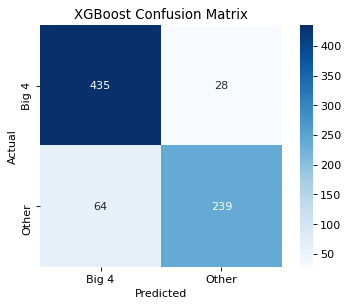

In [6]:
#view confusion matrix
confusion = confusion_matrix(y_test, y_pred_test)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Big 4', 'Other'],
           yticklabels=['Big 4', 'Other'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix');

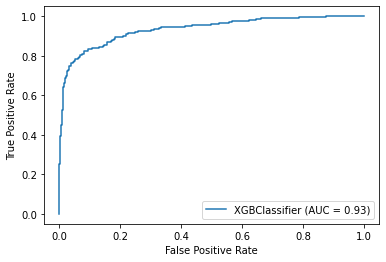

In [7]:
#view roc curve
metrics.plot_roc_curve(fit_model, X_test, y_test)
plt.show()

In [9]:
filename = 'xgboost.pkl'
pickle.dump(fit_model, open(filename, 'wb'))